### Use and train a Data Reuploading model

In this tutorial we show how to setup and train a quantum machine learning model implementing a Data Reuploading strategy.

The main idea behind data reuploading strategies is that data are encoded more than once into our quantum machine learning model. 

<img src="./figures/reuploading.svg" width="600" height="400" alt="My Image">

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn

from qibo import Circuit, gates, hamiltonians, set_backend, construct_backend

from qiboml.models.encoding import PhaseEncoding
from qiboml.models.decoding import Expectation
from qiboml.interfaces.pytorch import QuantumModel
from qiboml.operations.differentiation import PSR, Jax

[Qibo 0.2.17|INFO|2025-03-14 15:52:36]: Using qiboml (pytorch) backend on cpu


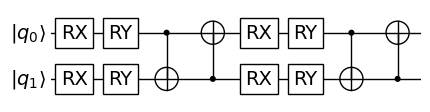

In [5]:
set_backend("qiboml", platform="pytorch")

nqubits = 2

# Encoding layer
encoding_circ = PhaseEncoding(
    nqubits=nqubits, 
    encoding_gate=gates.RX
)

# Trainable layer
def trainable_circuit(entanglement=True):
    trainable_circ  = Circuit(nqubits)
    for q in range(nqubits):
        trainable_circ.add(gates.RY(q=q, theta=np.random.randn()))
    if nqubits > 1 and entanglement:
        [trainable_circ.add(gates.CNOT(q%nqubits, (q+1)%nqubits) for q in range(nqubits))]
    return trainable_circ

# Decoding layer
decoding_circ = Expectation(
    nqubits=nqubits, 
    backend=construct_backend("numpy")
)

# The whole model
model = QuantumModel(
    circuit_structure=[
        encoding_circ, 
        trainable_circuit(entanglement=True),
        encoding_circ, 
        trainable_circuit(entanglement=True)
    ],
    decoding=decoding_circ,
    differentiation=PSR(),    
)

model.draw()

In [6]:
# Prepare the training dataset (using f(x) = sin(x) as the target function)
def f(x):
    return 1 * torch.sin(x)  ** 2 - 0.3 * torch.cos(x) 

num_samples = 30
x_train = torch.linspace(0, 2 * np.pi, num_samples, dtype=torch.float32).unsqueeze(1)
y_train = f(x_train)

y_train = 2 * ( (y_train - min(y_train)) / (max(y_train) - min(y_train)) - 0.5 )

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

In [8]:
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    # Use torch.stack to get a tensor of shape (100, 1, 1)
    y_pred = torch.stack([model(x) for x in x_train])
    # Remove the extra singleton dimension so that y_pred has shape (100, 1)
    y_pred = y_pred.squeeze(-1)
    
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

Epoch 0: Loss = 1.284383773803711
Epoch 10: Loss = 0.10420988500118256
Epoch 20: Loss = 0.00671572657302022
Epoch 30: Loss = 0.017327163368463516
Epoch 40: Loss = 0.003145190654322505
Epoch 50: Loss = 0.0024936518166214228
Epoch 60: Loss = 0.00040821387665346265
Epoch 70: Loss = 0.000171852923813276
Epoch 80: Loss = 0.00011585772153921425
Epoch 90: Loss = 2.4432074496871792e-05


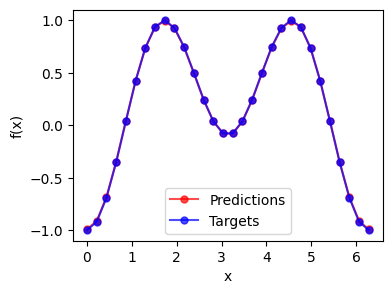

In [10]:
plt.figure(figsize=(4, 4 * 6 / 8), dpi=100)
plt.plot(
    x_train, 
    y_pred.detach().numpy(), 
    marker=".",
    markersize=10,
    color="red", 
    label="Predictions",
    alpha=0.7
)
plt.plot(
    x_train, 
    y_train,
    marker=".",
    markersize=10,
    color="blue", 
    label="Targets",
    alpha=0.7
)
plt.xlabel(r"x")
plt.ylabel(r"f(x)")
plt.legend()
plt.show()